Clasificación clientes riesgo crediticio

# Acerca del dataset


Contexto

Una compañía automotriz tiene planes de ingresar a nuevos mercados con sus productos existentes (P1, P2, P3, P4 y P5). Después de una intensa investigación de mercado, han deducido que el comportamiento del nuevo mercado es similar al de su mercado actual.

En su mercado actual, el equipo de ventas ha clasificado a todos los clientes en 4 segmentos (A, B, C, D). Luego, realizaron un alcance y comunicación segmentados para diferentes segmentos de clientes. Esta estrategia les ha funcionado excepcionalmente bien. Planean utilizar la misma estrategia para los nuevos mercados y han identificado 2627 nuevos clientes potenciales.

Se requiere que ayudes al gerente a predecir el grupo correcto de los nuevos clientes.

#Planteamiento de objetivos e hipótesis


#Features

Variables:

- ID: ID único
- Gender: Género del cliente
- Ever_Married: Estado marital del cliente
- Age: Edad del cliente
- Graduated: Si el cliente se graduó o no (Si/No)
- Profession: Profesión del cliente
- Work_Experience: Experience laboral (Años)
- Spending_Score: Spending score (scoring asignado en función del comportamiento del cliente y la naturaleza del gasto) del cliente
- Family_Size: Cantidad de miembros en la familia del cliente (Incluye al cliente)
- Var_1: Categoría anónima del cliente
- Segmentation: Variable objetivo, segmento del cliente.

# Importación

In [ ]:
# Importación de datos
import os
from google.colab import files

# Creacion y modificación dataframes
import pandas as pd
import numpy as np

# EDA
import missingno as msno

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Para normalización / preprocesamiento
!pip install category_encoders
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from category_encoders import LeaveOneOutEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler

#Modelado
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

#Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.metrics import specificity_score

#Evaluación y tuning de modelo
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV

# Biblioteca para reutilizar el tuning del modelo
import joblib


# Warnings a saltar
import warnings
warnings.filterwarnings('ignore')


# Instalar la biblioteca de Kaggle
!pip install kaggle

#Creación dataframe

Importamos la Key de Kaggle y el Dataset al entorno

In [ ]:
os.makedirs('/root/.kaggle/', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d kaushiksuresh147/customer-segmentation
!unzip customer-segmentation.zip -d customer-segmentation

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation
License(s): CC0-1.0
customer-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  customer-segmentation.zip
replace customer-segmentation/Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
for dirname, _, filenames in os.walk('/content/customer-segmentation'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


train = pd.read_csv('/content/customer-segmentation/Train.csv')
test = pd.read_csv('/content/customer-segmentation/Test.csv')

In [ ]:
print(train.head())
print("--------------------------------------------------------------------------------------------------")
print(test.head())

Las dos tablas tienen las mismas features

In [ ]:
df = pd.concat([train,test])
backup = df.copy() #Hacemos un df backup por si acaso.

Data frame creado, comenzamos con el EDA

#EDA Pre-Cleaning

In [75]:
df.head(10)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


In [76]:
df.describe()

,ID,Age,Work_Experience,Family_Size
count,10695.000000,10695.000000,9597.000000,10247.000000
mean,463468.088640,43.511828,2.619777,2.844052
std,2600.966411,16.774158,3.390790,1.536427
min,458982.000000,18.000000,0.000000,1.000000
25%,461220.500000,30.000000,0.000000,2.000000
50%,463451.000000,41.000000,1.000000,3.000000
75%,465733.500000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10695 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1002.7+ KB


Parece que la mayoría de columnas tienen el tipo de dato correcto, pero tienen diferente cantidad de longitudes. Probablemente tengamos muchos Nan a tratar

In [78]:
for col in df.columns:
    print(f'Valores únicos de {col}:\n {df[col].unique()}\n')
    print('--'*40)

Valores únicos de ID:
 [462809 462643 466315 ... 467938 467960 467968]

--------------------------------------------------------------------------------
Valores únicos de Gender:
 ['Male' 'Female']

--------------------------------------------------------------------------------
Valores únicos de Ever_Married:
 ['No' 'Yes' nan]

--------------------------------------------------------------------------------
Valores únicos de Age:
 [22 38 67 40 56 32 33 61 55 26 19 70 58 41 31 79 49 18 36 35 45 42 83 27
 28 47 29 57 76 25 72 48 74 59 39 51 30 63 52 60 68 86 50 43 80 37 46 69
 78 71 82 23 20 85 21 53 62 75 65 89 66 73 77 87 84 81 88]

--------------------------------------------------------------------------------
Valores únicos de Graduated:
 ['No' 'Yes' nan]

--------------------------------------------------------------------------------
Valores únicos de Profession:
 ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]

------

La variable objetivo para estar balanceada, lo único extraño se puede identificar es que casi todas las features numéricas están formateadas como floats y en verdad son ints, por comodidad podría modificarse.

A su vez, el contenido de Var_1 está ingresado como string, habrá que stripear y dejar solo los números correspondientes.

La feature 'Segmentation' es la variable que nos permitirá medir el accuracy de nuestro modelo futuro.

In [79]:
df.duplicated().sum()


38

Existen filas duplicadas en el dataset

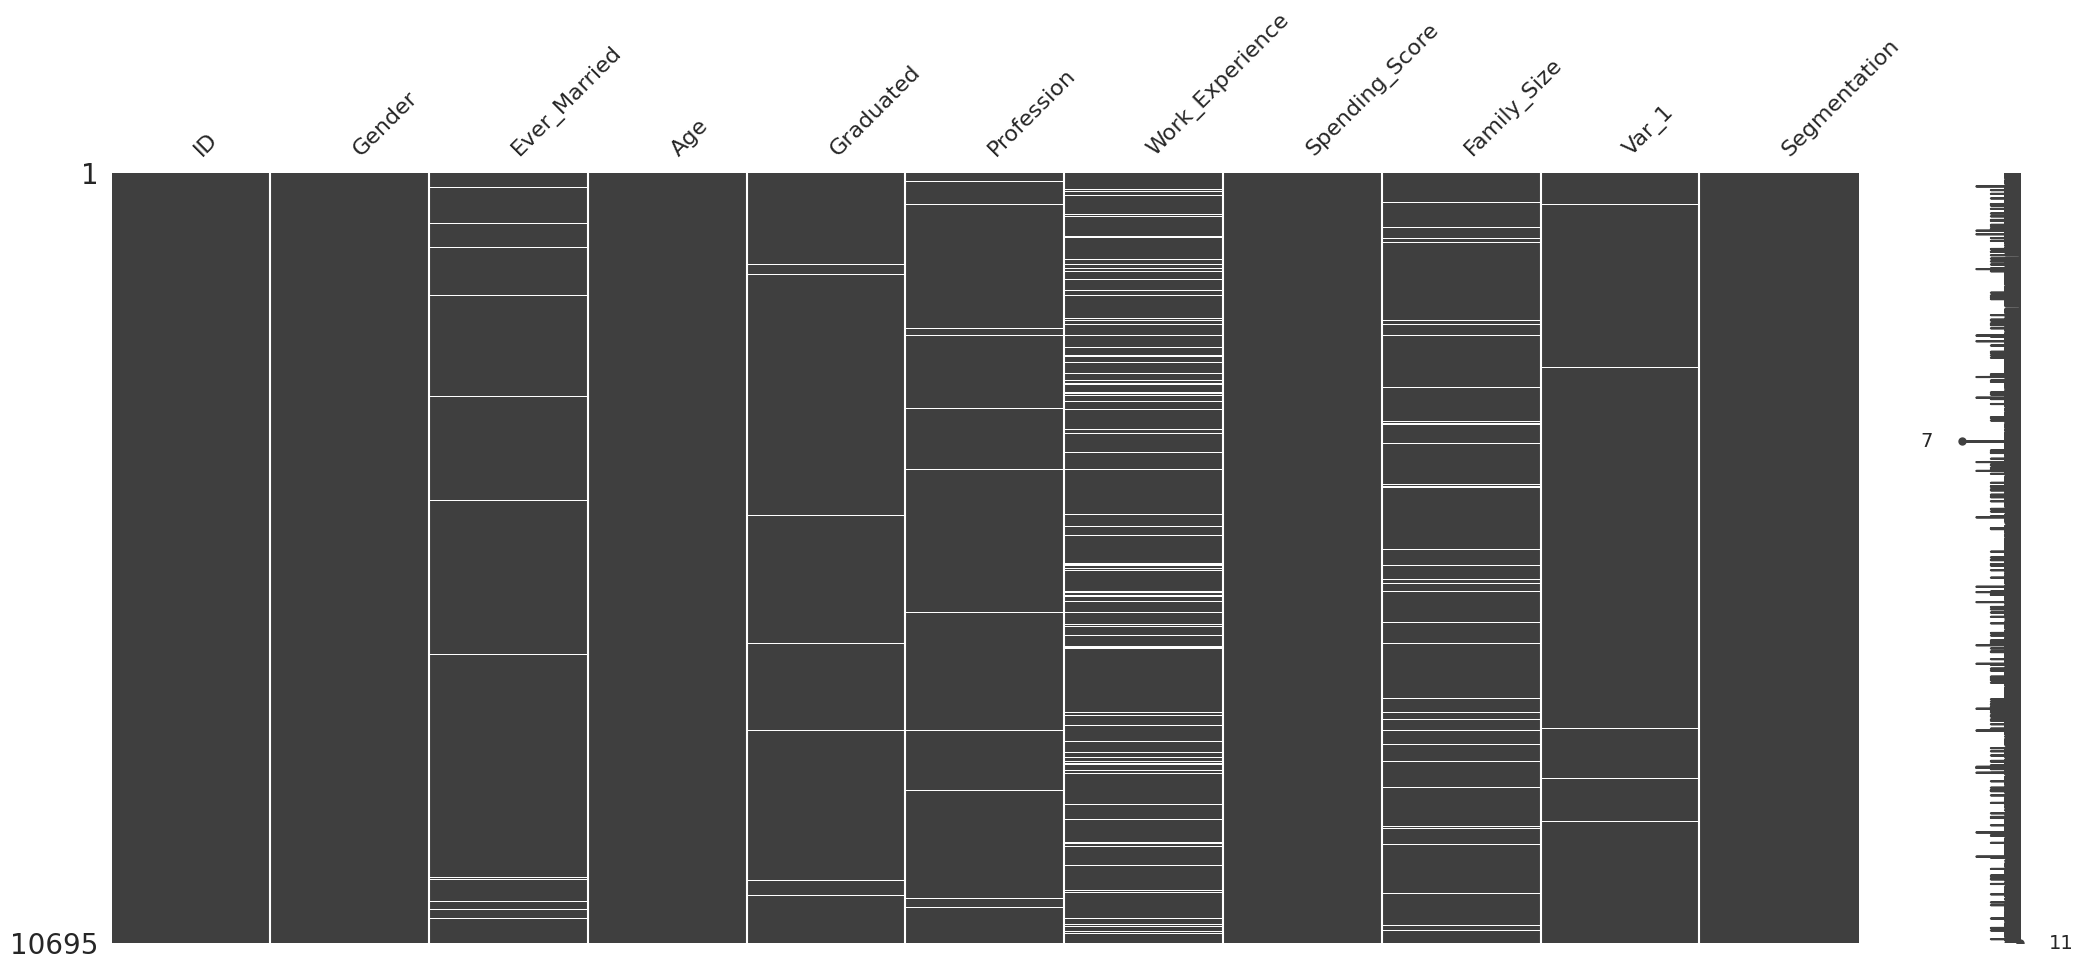

<Figure size 400x200 with 0 Axes>

In [80]:
msno.matrix(df)
plt.figure(figsize=(4, 2))
plt.show()

Podemos ver que en varias columnas hay valores nulos.
En algunas podría ser una respuesta válida, tales como 'Work_Experience','Profession' o 'Graduated'. Pero en el resto de las variables me llama un poco la atención, y podríamos plantearnos reemplazar esos valores o eliminarlos.

In [ ]:
df.hist(bins=25,figsize=(15,10),color='#6940A8') #Histograma de las variables numéricas
plt.show()

# 🧹Reformateo y Limpieza

COmenzamos dropeando la columna ID ya que poseemos una por defecto y no nos proporciona info útil.

In [ ]:
df = (df.drop(['ID'], axis=1))
df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...
2622,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6,B
2623,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6,A
2624,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6,C
2625,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4,C


A los valores nulos de las siguientes features se les asignará el valor 0 o "No" para mantener una mayor cantidad de datos, por más pocos que sean.

Features y elementos a tratar:
1. Intentar mantener la mayor cantidad de datos, reemplazando nulos por valores más que eliminándolos.
2. Dropeamos duplicados y nulos, habiendo modificado los valores nulos de features específicas.
3. Hacer numérica la feature `'Var_1'`
4. Reformateo al tipo de dato correcto en columnas numéricas

##Manipulación de nulos y reformateo

1.

In [81]:
df['Work_Experience'] = df['Work_Experience'].fillna(0)
df['Ever_Married'] = df['Ever_Married'].fillna("No")
df['Graduated'] = df['Graduated'].fillna("No")

2.

In [82]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

3.


In [83]:
#Eliminamos el string y hacemos la feature de tipo int
df['Var_1'] = df['Var_1'].str.replace('Cat_', '').astype(int)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9976 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9976 non-null   int64  
 1   Gender           9976 non-null   object 
 2   Ever_Married     9976 non-null   object 
 3   Age              9976 non-null   int64  
 4   Graduated        9976 non-null   object 
 5   Profession       9976 non-null   object 
 6   Work_Experience  9976 non-null   float64
 7   Spending_Score   9976 non-null   object 
 8   Family_Size      9976 non-null   float64
 9   Var_1            9976 non-null   int64  
 10  Segmentation     9976 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 935.2+ KB


4.

In [85]:
# Formateamos correctamente las features
df['Work_Experience'] = df['Work_Experience'].astype(int)
df['Family_Size'] = df['Family_Size'].astype(int)

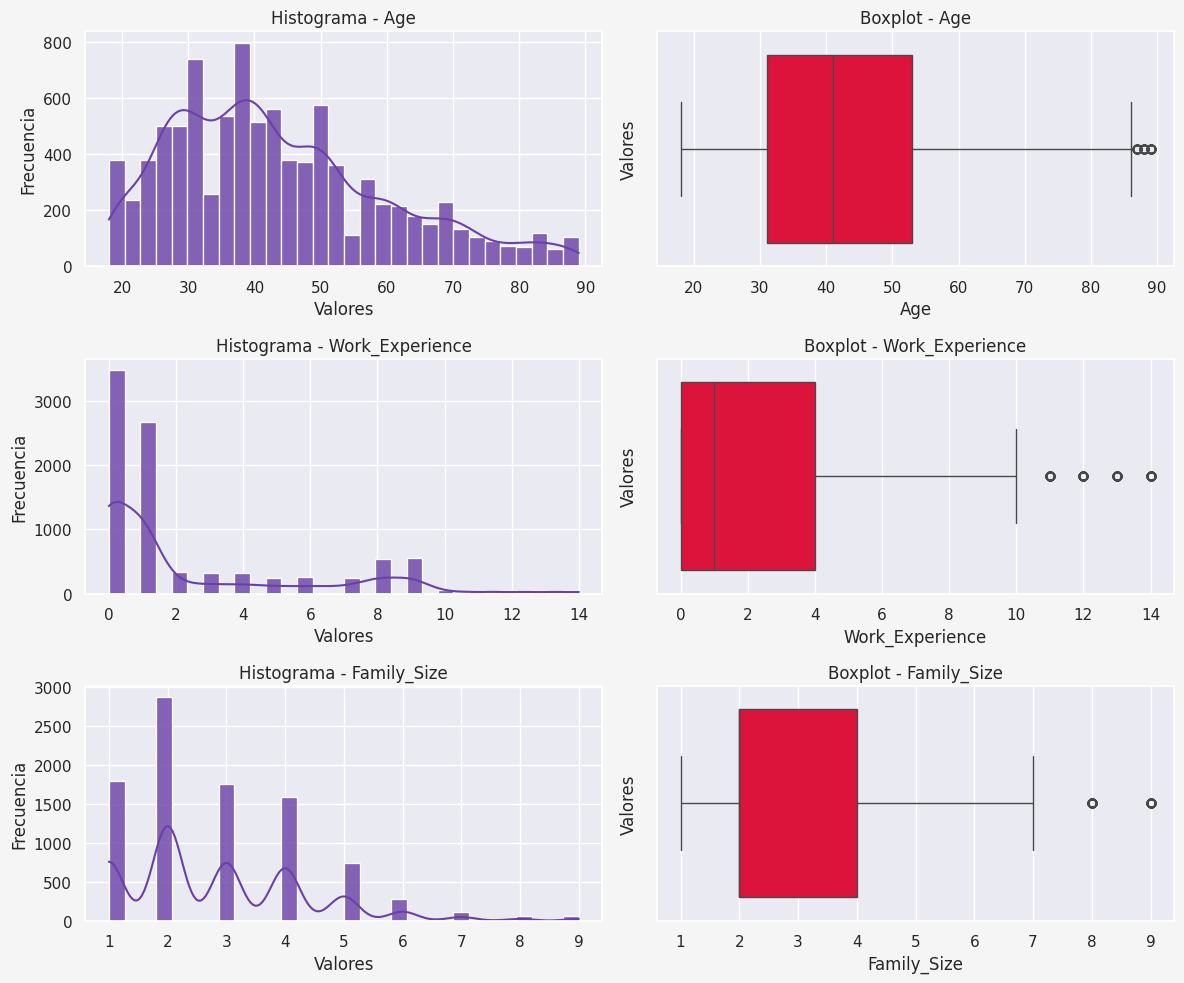

In [ ]:
columnas_seleccionadas = ['Age', 'Work_Experience','Family_Size']

# Prepara una grilla de subplots con un gris claro
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10), facecolor='whitesmoke')
sns.set_theme(style='darkgrid')
# Itera a través de las columnas seleccionadas y hace histogramas y boxplots
for i, columna in enumerate(columnas_seleccionadas): #Enumerate permite iterar en una lista, returneando una tupla que contiene el índice de cada elemento y el elemento mismo.
    # Histograma
    sns.histplot(df[columna], bins=30, color='#6940A8', alpha=0.8, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histograma - {columna}')
    axes[i, 0].set_xlabel('Valores')
    axes[i, 0].set_ylabel('Frecuencia')

    # Boxplot
    sns.boxplot(x=df[columna], ax=axes[i, 1], color='crimson', boxprops=dict(facecolor='crimson'))
    axes[i, 1].set_title(f'Boxplot - {columna}')
    axes[i, 1].set_ylabel('Valores')

# Ajuste de espacio
plt.tight_layout()

# Muestra el gráfico
plt.show()

In [ ]:
df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1,Low,4,4,D
1,Female,Yes,38,Yes,Engineer,0,Average,3,4,A
2,Female,Yes,67,Yes,Engineer,1,Low,1,6,B
3,Male,Yes,67,Yes,Lawyer,0,High,2,6,B
4,Female,Yes,40,Yes,Entertainment,0,High,6,6,A
...,...,...,...,...,...,...,...,...,...,...
2621,Female,No,35,Yes,Entertainment,1,Low,2,6,D
2622,Male,No,29,No,Healthcare,9,Low,4,6,B
2623,Female,No,35,Yes,Doctor,1,Low,1,6,A
2624,Female,No,53,Yes,Entertainment,0,Low,2,6,C


In [ ]:
count_A = df['Segmentation'].value_counts().get("A", 0)
count_B = df['Segmentation'].value_counts().get("B", 0)
count_C = df['Segmentation'].value_counts().get("C", 0)
count_D = df['Segmentation'].value_counts().get("D", 0)
print(f'A: {count_A}')
print(f'B: {count_B}')
print(f'C: {count_C}')
print(f'D: {count_D}')

A: 2505
B: 2196
C: 2103
D: 2460


##IQR - Limpieza Outliers

In [ ]:
# Utilizamos las mismas columnas seleccionadas anteriormente
columnas_seleccionadas = ['Age', 'Work_Experience', 'Family_Size']
suma = 0

# Diccionario para contar los outliers
outliers = {}

def conteo_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1

    # Definiendo el límite de los outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Encontrar y contar los outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    contar_outliers = outliers.shape[0]
    return contar_outliers


# Iteración de la función en cada columna y almacenamiento de los resultados
for columna in columnas_seleccionadas:
    contar_outliers = conteo_outliers(df, columna)
    outliers[columna] = contar_outliers

# Impresión de los resultados
print("Cantidad de Outliers:")
for columna, cant in outliers.items():
    suma += cant # Variable para aclaración de lo eliminado
    print(f"{columna}: {cant}")

# Imprimir la suma total de outliers eliminados
print(f"Total de outliers encontrados: {suma}")

Cantidad de Outliers:
Age: 105
Work_Experience: 232
Family_Size: 123
Total de outliers encontrados: 460


In [ ]:
# Impresión de resultados luego de eliminar outliers
print(f"Filas totales: {df.shape[0]}")
print(f"Se encontraron {suma} outliers en un total de {df.shape[0]} valores.")
print(f"Eso que representa un {suma / df.shape[0] * 100:.1f}% del df original.")

Filas totales: 9264
Se encontraron 460 outliers en un total de 9264 valores.
Eso que representa un 5.0% del df original.


Se eligió eliminar los outliers ya que se hicieron pruebas y estos le restaban a la precisión del modelo final.

In [ ]:
count_A = df['Segmentation'].value_counts().get("A", 0)
count_B = df['Segmentation'].value_counts().get("B", 0)
count_C = df['Segmentation'].value_counts().get("C", 0)
count_D = df['Segmentation'].value_counts().get("D", 0)
print(f'A: {count_A}')
print(f'B: {count_B}')
print(f'C: {count_C}')
print(f'D: {count_D}')

A: 2505
B: 2196
C: 2103
D: 2460


A: 2505
B: 2196
C: 2103
D: 2460

La eliminación de los outliers no presentó una gran diferencia respecto a los gráficos.

Se decidió no eliminar los outliers ya que no era beneficioso para el modelo.

#EDA Post-Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9264 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           9264 non-null   object
 1   Ever_Married     9264 non-null   object
 2   Age              9264 non-null   int64 
 3   Graduated        9264 non-null   object
 4   Profession       9264 non-null   object
 5   Work_Experience  9264 non-null   int64 
 6   Spending_Score   9264 non-null   object
 7   Family_Size      9264 non-null   int64 
 8   Var_1            9264 non-null   int64 
 9   Segmentation     9264 non-null   object
dtypes: int64(4), object(6)
memory usage: 796.1+ KB


Graficamos las columnas categóricas

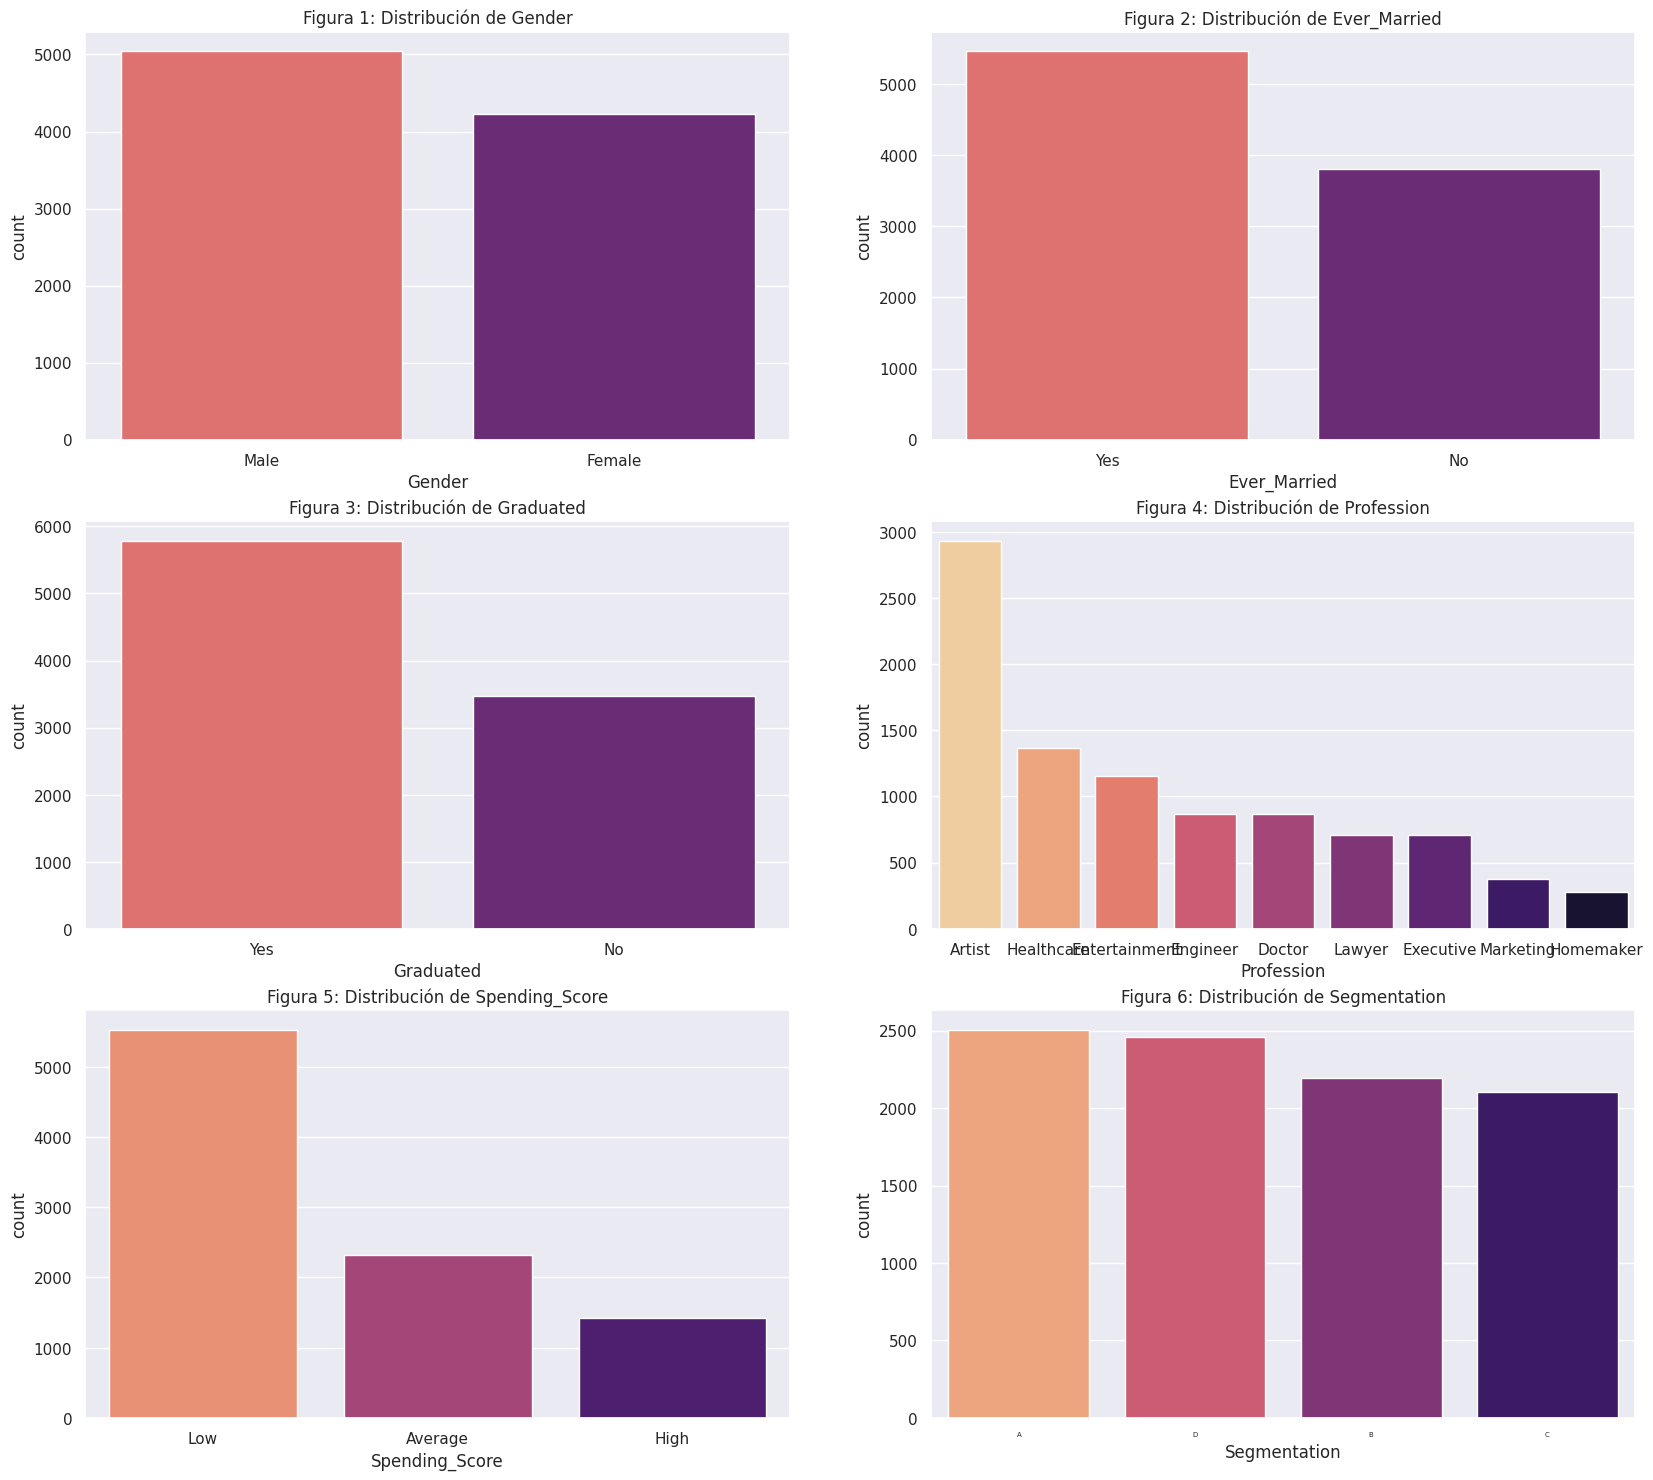

In [ ]:
variables = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score','Segmentation']

# Creación de grilla subplot 3x2
fig, ejes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))

# Flattenear los ejes para simplificar la visualización
ejes = ejes.flatten()

# Iteración sobre cada característica y crear un gráfico
for i, variable in enumerate(variables):
    #Ordenamos de forma descendente los valores para facilitar la visualización
    ordenar = df[variable].value_counts().index

    #Graficamos
    sns.countplot(df, x=variable, order=ordenar, ax=ejes[i],palette='magma_r')

    #leyenda
    ejes[i].set_title(f'Figura {i+1}: Distribución de {variable}')

    # Achicamos los nombres para correcta visualizacion
    plt.tick_params(axis='x', labelsize= 5)



In [ ]:
for feature in ['Age', 'Work_Experience', 'Family_Size','Var_1']:
    plot_numerical(feature)


NameError: name 'plot_numerical' is not defined

Graficamos las columnas numéricas

-----------------------------------
COLUMNAS NUMÉRICAS
-----------------------------------


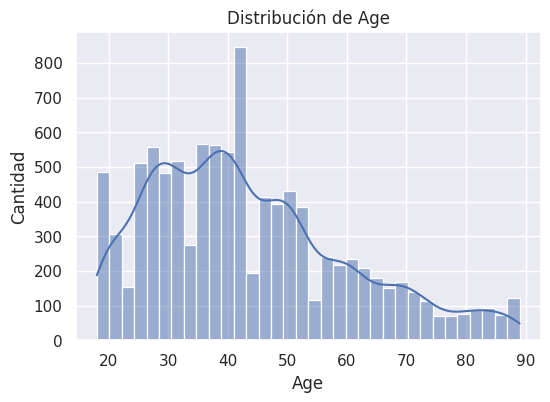

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


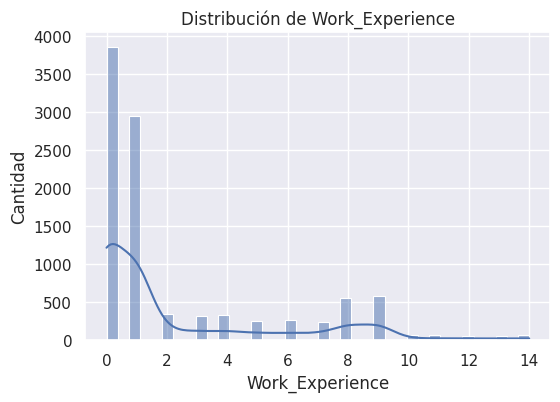

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


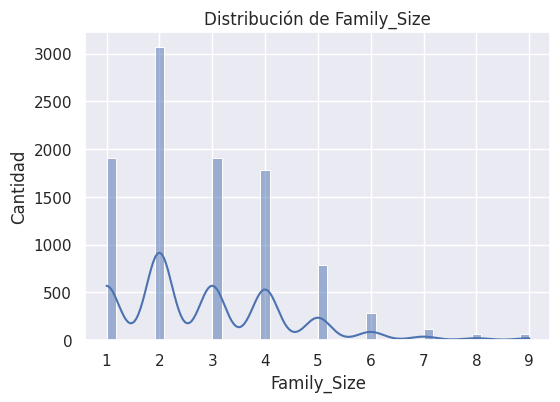

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


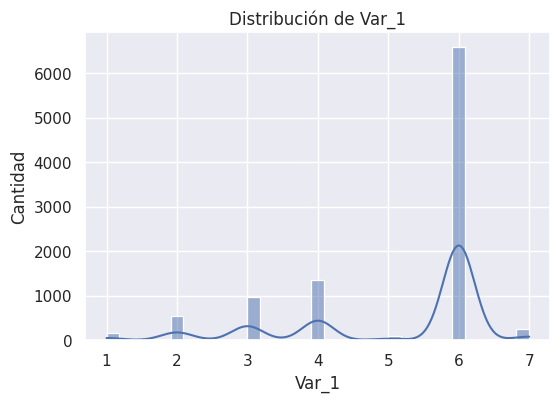

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°


In [86]:
# Graficar las características numéricas por separado
num_features = ['Age', 'Work_Experience', 'Family_Size','Var_1']

print("-----------------------------------")
print("COLUMNAS NUMÉRICAS")
print("-----------------------------------")
for feature in num_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribución de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Cantidad')
    plt.show()
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°") #Para separar los gráficos

#Feature Engineering

##Encoding

In [87]:
#Separamos las categorías cualitativas de las cuantitativas
categoricos = df.select_dtypes(include=object)
numericos = df.select_dtypes(exclude=object)

In [88]:
#Reemplazamos todas las variables categoricas por valores numéricos enteros
#Aplicamos label encoder a cada columna categórica
for i in range(0, categoricos.shape[1]):
  categoricos[categoricos.columns[i]] = lab.fit_transform(categoricos.iloc[:, i])

scaler = StandardScaler()
#Hacemos una copia para por si se quiere usar la variable númericos en un futuro
numericos_escalados = numericos.copy()


#Escalamos los valores numéricos
numericos_escalados[numericos.columns] = scaler.fit_transform(numericos)
numericos = numericos_escalados[numericos.columns]

In [89]:
#Concatenamos las filas para tener nuestro df completamente numérico
dfLE = pd.concat([numericos,categoricos],axis=1)
#dfLE = df + "Label Encoder"
dfLE

,ID,Age,Work_Experience,Family_Size,Var_1,Gender,Ever_Married,Graduated,Profession,Spending_Score,Segmentation
0,-0.259762,-1.290147,-0.412178,0.751366,-0.815363,1,0,0,5,2,3
1,-0.323871,-0.333032,-0.713835,0.100591,-0.815363,0,1,1,2,0,0
2,1.094253,1.401739,-0.412178,-1.200959,0.598519,0,1,1,2,2,1
3,-0.674540,1.401739,-0.713835,-0.550184,0.598519,1,1,1,7,1,1
4,-0.313830,-0.213393,-0.713835,2.052915,0.598519,0,1,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2622,1.727234,-0.871409,2.001080,0.751366,0.598519,1,0,0,5,2,1
2623,1.728779,-0.512491,-0.412178,-1.200959,0.598519,0,0,1,1,2,0
2624,1.729551,0.564264,-0.713835,-0.550184,0.598519,0,0,1,3,2,2
2625,1.729937,0.205345,-0.412178,1.402140,-0.815363,1,1,1,4,1,2


Por lo tanto, a partir de ahora en la variable segmentación:
- A = 0
- B = 1
- C = 2
- D = 3

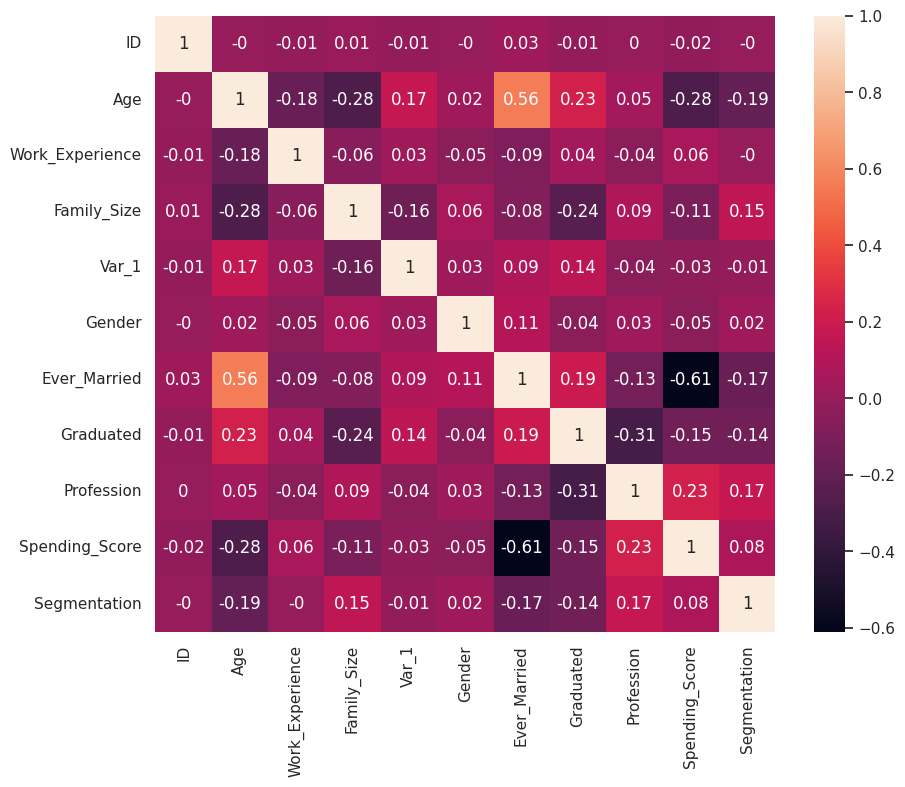

In [90]:
# Separamos las columnas numéricas del resto
columnas_numericas = dfLE.select_dtypes(exclude=['object', 'category'])

#Hacemos matriz de corr solo con columnas numéricas
matriz_corr = columnas_numericas.corr().round(2)

plt.figure(figsize=(10, 8))

sns.heatmap(matriz_corr, annot=True)
plt.show()

#Modelado 1

Ya habiendo encodeado todas las variables, voy a dividir el dataframe en 2 partes.
1. Separo mis variables para predecir (x) de mi variable objetivo (y)
2. Separo los dataframes x e y en training y test.

Las columnas innecesarias ya fueron dropeadas en la parte de limpieza.

Variable Objetivo: `'Segmentation'`

In [91]:
y = dfLE['Segmentation']
x = dfLE.drop(['Segmentation'],axis = 1)

In [92]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [93]:
from sklearn.metrics import f1_score

def modelado(modelo, x_train, x_test, y_train, y_test):
    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')  # Cambiado de especificidad a f1-score

    return accuracy, precision, recall, f1


3. Recall (Sensibilidad o Tasa de Verdaderos Positivos)
El recall es la proporción de verdaderos positivos sobre el total de instancias reales positivas. Mide cuántas de las instancias realmente positivas fueron predichas correctamente.

Ejemplo: Si un modelo identifica correctamente 40 de 50 instancias positivas, el recall es 80%.

In [94]:
modelos = {
    'DecisionTreeC': DecisionTreeClassifier(),
    'GradientBoostingC': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestC': RandomForestClassifier(n_estimators=100),
    'LGBC': lgb.LGBMClassifier(random_state=42,),
    'XGBC': xgb.XGBClassifier(n_estimators=100, seed=27)
}

Ahora vamos a modularizar una función llamada Resultados_Algoritmo.

Esta función nos dará un resultado impreso de los accuracies de cada modelo. Lo único que cambiaría, razón por la que la modularizamos, es el input de los train y los test. Esto se hace para calcular fácilmente los accuracies de diferentes grupos de datos con los mimos modelos.

In [95]:
def Evaluacion_Algoritmos(modelos, x_train, x_test, y_train, y_test):
  # Diccionario para almacenar los resultados del entrenamiento
  resultados = {'Algoritmo': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

  for nombre, modelo in modelos.items():
      # Utilizamos la función modelado para obtener métricas
      accuracy, precision, recall, f1 = modelado(modelo, x_train, x_test, y_train, y_test)

      # Convertimos las métricas a porcentaje y luego a cadena
      accuracy_str = f"{accuracy * 100:.2f}%"
      precision_str = f"{precision * 100:.2f}%"
      recall_str = f"{recall * 100:.2f}%"
      f1_str = f"{f1 * 100:.2f}%"

      # Apendeamos los valores al diccionario de resultados
      resultados['Algoritmo'].append(nombre)
      resultados['Accuracy'].append(accuracy_str)
      resultados['Precision'].append(precision_str)
      resultados['Recall'].append(recall_str)
      resultados['F1-Score'].append(f1_str)
  # Returneamos los resultados
  return resultados


In [96]:
df_resultados = Evaluacion_Algoritmos(modelos, x_train, x_test, y_train, y_test)
# Convertimos los resultados a un DataFrame ordenado para visualización
pd.DataFrame(df_resultados).sort_values(by='Accuracy',ascending=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 7980, number of used features: 10
[LightGBM] [Info] Start training from score -1.337862
[LightGBM] [Info] Start training from score -1.482507
[LightGBM] [Info] Start training from score -1.455287
[LightGBM] [Info] Start training from score -1.283041


,Algoritmo,Accuracy,Precision,Recall,F1-Score
1,GradientBoostingC,47.09%,46.22%,47.09%,46.25%
5,LGBC,46.84%,46.24%,46.84%,46.37%
3,LogisticRegression,45.29%,44.49%,45.29%,42.48%
6,XGBC,44.79%,44.41%,44.79%,44.49%
2,K-Nearest Neighbors,42.64%,43.20%,42.64%,42.68%
4,RandomForestC,41.53%,41.16%,41.53%,41.21%
0,DecisionTreeC,36.82%,36.92%,36.82%,36.87%


Se puede ver que el algoritmo con mayores métricas en los 4 apartados fue GradientBoostingC, por lo tanto, en primera instancia utilizaremos ese para la clasificación

##Balanceo de variables

Realizamos el balanceo luego de encodear ya que se precisan valores numéricos para realizar este procedimiento.

### UnderSampler

In [97]:
print("Distribución de clases antes del balanceo:", Counter(y_train))

undersampler = RandomUnderSampler(random_state=42)

for nombre, modelo in modelos.items():
  x_train_unders, y_train_unders = undersampler.fit_resample(x_train, y_train)


print("Distribución de clases después del balanceo:", Counter(y_train_unders))

Distribución de clases antes del balanceo: Counter({3: 2212, 0: 2094, 2: 1862, 1: 1812})
Distribución de clases después del balanceo: Counter({0: 1812, 1: 1812, 2: 1812, 3: 1812})


In [98]:
x_train = x_train_unders
y_train = y_train_unders

#Utilizamos la misma función con los trains balanceados y mismos test.
df_resultados = Evaluacion_Algoritmos(modelos, x_train, x_test, y_train, y_test)


# Convertimos los resultados a un DataFrame ordenado para visualización
pd.DataFrame(df_resultados).sort_values(by='Accuracy',ascending=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 7248, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


,Algoritmo,Accuracy,Precision,Recall,F1-Score
1,GradientBoostingC,46.44%,45.81%,46.44%,46.04%
3,LogisticRegression,45.74%,44.52%,45.74%,44.34%
5,LGBC,45.34%,44.92%,45.34%,45.10%
6,XGBC,44.99%,44.68%,44.99%,44.81%
2,K-Nearest Neighbors,42.84%,43.74%,42.84%,43.12%
4,RandomForestC,42.69%,42.47%,42.69%,42.56%
0,DecisionTreeC,36.32%,36.52%,36.32%,36.41%


## Importancia de variables

Se usará el mejor modelo para trainear los udatos y se empleará el modelo fitteado para hacer predicciones con y_test.

In [99]:
# Traineamos el modelo con  GradientBoostingC
GBC = GradientBoostingClassifier()
GBC.fit(x_train, y_train)
accuracy_score = GBC.score(x_test, y_test)
y_pred = GBC.predict(x_test)


In [ ]:
importancia = pd.Series(data=GBC.feature_importances_, index=x.columns).sort_values(ascending=False)

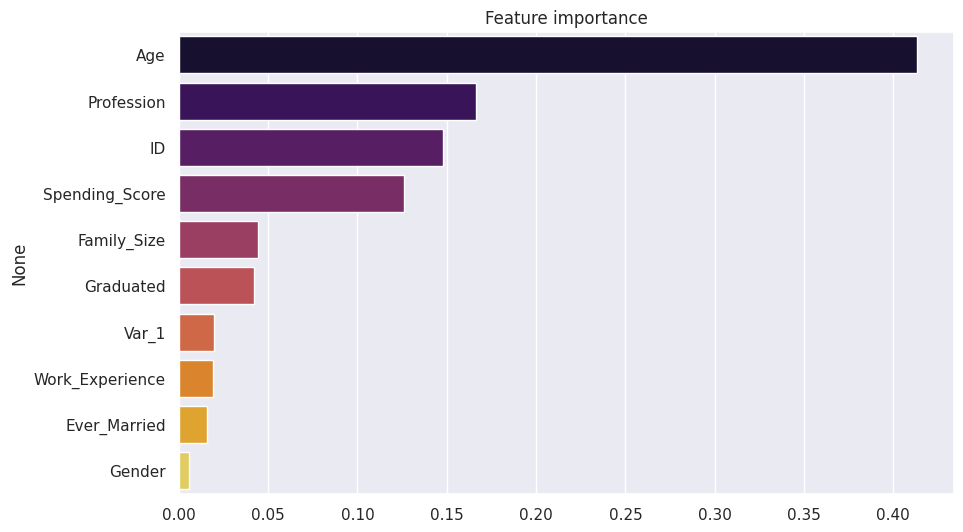

In [101]:
plt.figure(figsize=(10,6))
plt.title("Feature importance")
ax = sns.barplot(y=importancia.index, x=importancia.values, orient='h', palette='inferno')

Las variables más improtantes son `'Profession'`,`'Age'`, `'Spending_Score'`, `'Family_Size'`, `'Work_Experience'`, `'Var_1'`.

Si recordamos la matriz de correlación, `'Age'`,`'Work_Experience'`y `'Var_1'`tenían una correlación de 1. Por lo tanto, ya tiene más sentido deshacernos de alguna de las variables para simplificar el modelo y tal vez el accuracy mejore.

## Evaluación del modelo

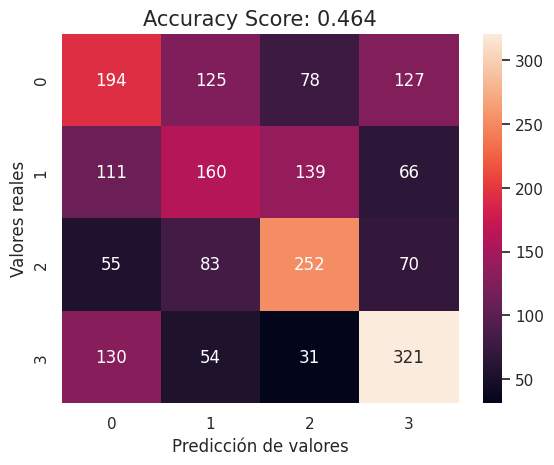

In [102]:

# Utilizamos las métricas obtenidas para imprimirlo junto con la matriz
score = round(accuracy_score, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicción de valores')
plt.ylabel('Valores reales')
plt.title('Accuracy Score: {0}'.format(score), size=15)
plt.show()

In [103]:
err

NameError: name 'err' is not defined

#EJECUTAR EL TUNING ACÁ DESPUÉS PARA VER QUE ONDA


#Selección de características


Por nuestro estudio anterior sabemos que las variables más improtantes son:

In [ ]:
importancia.head(5)

¿Qué le ocurrirá a nuestras predicciones si les quitamos las variables con mayor correlatividad?



Probemos dejar de lado 'Age' y 'Work_Experience', variables que tenian  mucha correlatividad entre sí, y utilicemos solo las 3 más importantes que nos quedan.

In [ ]:
x_train = x_train[['Profession', 'Var_1', 'Spending_Score','Age']]
x_test = x_test[['Profession', 'Var_1', 'Spending_Score','Age']]

Ahora que ya sabes qué modelo vamos a utilizar (GBC), no hace falta hacer el diccionario para ver el reporte de resultados.

Vamos a fitear el modelo directamente con GBC


In [ ]:

modelo = GBC

# Definimos el método de evaluación
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Definimos la grilla
grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50,100, 200],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

# Configuramos GridSearchCV
search = GridSearchCV(estimator=modelo, param_grid=grid, cv=cv, scoring='accuracy',n_jobs=-1)

# Ajustamos el modelo con los datos de entrenamiento
resultado = search.fit(x_train, y_train)

# Mostramos los mejores parámetros encontrados
print(f"Mejores parámetros encontrados: {resultado.best_params_}")

# Evaluamos el mejor modelo
mejor_modelo = resultado.best_estimator_
accuracy = mejor_modelo.score(x_test, y_test)
print(f"Accuracy del mejor modelo: {accuracy:.2f}")

In [ ]:
# Definimos el modelo
modelo = GradientBoostingClassifier(n_estimators = 50, max_depth = 5, learning_rate = 0.1)

# Fit search to new training data
resultado = modelo.fit(x_train, y_train)

# Iniciamos y traineamos el modelo
score = resultado.score(x_test, y_test)
y_pred = resultado.predict(x_test)

# Calculamos y graficamos la matriz de confusión
score = round(accuracy_score(y_test, y_pred), 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size=15)
plt.show()

En términos de recursos, es algo muy útil saber que con solo 3 variables el modelo funciona tiene un accuracy de 0,002 menos que con TODAS las variables.

#Tuning del Modelo



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Las clases se encuentran en formato entero, y tenemos 4 clases
# Utilizamos el n_classes por adaptabilidad, pero podría ser = 4 también
n_classes = len(set(y_test))

# Binarizamos las etiquetas para calcular la curva ROC POR CLASE
y_test_binarizado = label_binarize(y_test, classes=range(n_classes))
y_pred_proba = mejor_modelo.predict_proba(x_test)

# Calculamos la curva ROC y el AUC para cada clase
fpr = dict() # Falsos positivos
tpr = dict() # Verdaderos positivos
roc_auc = dict() # AUC

for i in range(n_classes): #Por cada clase...
    fpr[i], tpr[i], _ = roc_curve(y_test_binarizado[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarizado[:, i], y_pred_proba[:, i])

# Gráfica de las curvas ROC para cada clase
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--') #Diagonal en el medio
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

Conclusiones en base al gráfico:

Clase 3 (AUC = 0.79):

El modelo tiene la mejor capacidad para distinguir la Clase 3 de las otras clases, con un AUC de 0.79. Esto indica un buen rendimiento, aunque no perfecto.
Clase 2 (AUC = 0.74):

El modelo también tiene un buen rendimiento para la Clase 2, con un AUC de 0.75. Esto sugiere que el modelo es razonablemente bueno para clasificar esta clase.
Clase 1 (AUC = 0.68) y Clase 0 (AUC = 0.66):

El rendimiento del modelo para las Clases 1 y 0 es menor en comparación con las otras clases, con un AUC de 0.68 y 0.66, respectivamente. Estos valores indican que el modelo tiene una capacidad moderada para distinguir estas clases de las demás.

Significado de AUC
- AUC = 1: Clasificación perfecta. El modelo clasifica todas las muestras correctamente.
- 0.7 < AUC < 0.9: Buen rendimiento. El modelo es bastante bueno para distinguir entre las clases.
- 0.6 < AUC < 0.7: Rendimiento aceptable. El modelo tiene una capacidad limitada para distinguir entre las clases.

# Deployment del modelo

In [ ]:

# age_input = float(input("Enter the client´s age: "))
# fam_input = int(input("Enter the client´s family size: "))
# prof_hc_input = str(input("Is the client´s profession Healthcare (Yes/No)? "))
# if prof_hc_input == "Yes":
#     prof_hc_input = 1
# else:
#     prof_hc_input = 0
# prof_e_input = str(input("Is the client´s profession Entertainment (Yes/No)? "))
# if prof_e_input == "Yes":
#     prof_e_input = 1
# else:
#     prof_e_input = 0
# prof_a_input = str(input("Is the client´s profession Artist (Yes/No)? "))
# if prof_a_input == "Yes":
#     prof_a_input = 1
# else:
#     prof_a_input = 0
# married_input = str(input("Has the client ever married (Yes/No)? "))
# if married_input == "Yes":
#     married_input = 1
# else:
#     married_input = 0
# grad_n_input = str(input("Is the client graduated (Yes/No)? "))
# if grad_n_input == "Yes":
#     grad_n_input = 0
# else:
#     grad_n_input = 1
# spend_input = int(input("Enter the client´s score level: "))

#Defining Xs
# X_mod_dep = pd.DataFrame({"Age":[age_input], "Family_Size":[fam_input], "Profession_Healthcare":[prof_hc_input],
#                           "Profession_Entertainment":[prof_e_input], "Profession_Artist":[prof_a_input],
#                           "Ever_Married_Yes":[married_input], "Graduated_No":[grad_n_input], "Spending_Score_Level":[spend_input]})

#Choosing an specific client for testing:
X_mod_dep = pd.DataFrame({"Age":[79], "Family_Size":[1], "Profession_Healthcare":[0],
                          "Profession_Entertainment":[0], "Profession_Artist":[1],
                          "Ever_Married_Yes":[1], "Graduated_No":[0], "Spending_Score_Level":[3]})

#Appending X_mod_dep to original X dataframe, so we can scale it all together next

X_with_X_mode_dep = X.append(X_mod_dep)
X_with_X_mode_dep = X_with_X_mode_dep.reset_index(drop=True)

#Scaling all features

from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()
X_scaled = sc_X.fit_transform(X_with_X_mode_dep)
X_scaled = pd.DataFrame(X_scaled)

#Recovering X_mod_dep row in dataframe after scaling

X_mod_dep = X_scaled.tail(1)

#Predicting results

prediction = model_xgbc.predict(X_mod_dep)
if prediction == 1:
    prediction_answer = "A"
if prediction == 2:
    prediction_answer = "B"
if prediction == 3:
    prediction_answer = "C"
if prediction == 4:
    prediction_answer = "D"

print("")
print(f"This client´s predicted Segmentation is: {prediction_answer}.")

- ---------------------------


Referencias y bibliografía:

[The power of independent component analysis ica on real world applications egg example](https://towardsdatascience.com/the-power-of-independent-component-analysis-ica-on-real-world-applications-egg-example-48df336a1bd8)